![example](images/director_shot.jpeg)

# Recent Movie Profitability Analysis

**Author:** Spencer Hadel
***

## Overview

This project will give Microsoft the data it needs to break into the movie industry, and maintain profitability when creating new content. 

## Business Problem

Microsoft will need to make sure that any content it creates yields a profit. This will come from properly allocating budgets to the correct types of films, set to release at the appropriate time of year for maximum domestic gross income. The following data will indicate which Genres, Budgets, and Release Dates to prioritize in order to maximize profits.

## Data Understanding
Using IMDB and The Numbers datasets, this analysis will show strong correlations between movie budgets and success, as well as the overall profitability of each movie genre. The data contains info on all recent movies released, their budgets, their gross income, and their genres.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Budget Data
This dataset includes movie names, as well as their production budget, demostic gross income, and worldwide gross income. For the purposes of this analysis, only the domestic gross will be taken into account, and profitability will be calculated using these values.

In [2]:
budgets_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


The "release_date" column will be separated into "month" and "year" columns in order analyze profitability by time of year. Additionally, a "monthNum" column will be used to simplify the ordering of data in this project.

In [3]:
#new month and year columns will be used by taking 
#the beginning and end of the release date info, respectively

budgets_df['year'] = budgets_df.release_date.str[-4:]
budgets_df['month'] = budgets_df.release_date.str[:3]

#create array assigning months to numbers, then add a new column using this array.
months_to_nums = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
budgets_df['monthNum'] = budgets_df['month'].apply(lambda x: months_to_nums.get(x))

In [4]:
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,monthNum
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec,12
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May,5
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun,6
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May,5
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec,12


In [5]:
#rename columns for readability

budgets_df.rename(columns={'production_budget': 'budget', 'domestic_gross': 'gross'}, inplace=True)

Next, the columns with budget or year information will be changed to integers, in order to properly graph their values in our results.

In [6]:
#replace commas and $ in monetary values, to prevent errors when converting to int
budgets_df['budget'].replace('[\$,]', '', regex=True, inplace=True)
budgets_df['gross'].replace('[\$,]', '', regex=True, inplace=True)

budgets_df['year'] = budgets_df['year'].astype(int)
budgets_df['budget'] = budgets_df['budget'].astype(int)
budgets_df['gross'] = budgets_df['gross'].astype(int)

In [7]:
#condirm successful change in type
budgets_df.dtypes

id                  int64
release_date       object
movie              object
budget              int32
gross               int32
worldwide_gross    object
year                int32
month              object
monthNum            int64
dtype: object

Next add a profit column, using the budget and gross income.

In [8]:
budgets_df['profit'] = budgets_df["gross"] - budgets_df["budget"]

### Titles Data
The next dataframe contains another piece of important data: each movies genre(s).

In [9]:
titles_df = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
titles_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


The only data we need from this table is the primary title of the movie, and its genre data.

In [10]:
#drop unnecessary data
titles_df.drop(['start_year', 'runtime_minutes', 'original_title'], axis=1, inplace=True)

#confirm data dropped
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   tconst         146144 non-null  object
 1   primary_title  146144 non-null  object
 2   genres         140736 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


### Creating Combined Dataset
Now all the data can be merged together to contain all the necessary information to draw our conclusions.

In [11]:
combined_df = pd.merge(titles_df, budgets_df, left_on='primary_title', right_on='movie', how = 'inner')
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3815 entries, 0 to 3814
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tconst           3815 non-null   object
 1   primary_title    3815 non-null   object
 2   genres           3743 non-null   object
 3   id               3815 non-null   int64 
 4   release_date     3815 non-null   object
 5   movie            3815 non-null   object
 6   budget           3815 non-null   int32 
 7   gross            3815 non-null   int32 
 8   worldwide_gross  3815 non-null   object
 9   year             3815 non-null   int32 
 10  month            3815 non-null   object
 11  monthNum         3815 non-null   int64 
 12  profit           3815 non-null   int32 
dtypes: int32(4), int64(2), object(7)
memory usage: 357.7+ KB


Drop rows with incomplete info, or where movie is a duplicate.

Also dropping rows with $0 listed as domestic gross income, because this is clearly incomplete data that could drastically skew results.

In [12]:
combined_df.dropna(inplace=True)
combined_df.drop_duplicates('movie')
combined_df= combined_df[combined_df['gross'] != 0]
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3813
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tconst           3214 non-null   object
 1   primary_title    3214 non-null   object
 2   genres           3214 non-null   object
 3   id               3214 non-null   int64 
 4   release_date     3214 non-null   object
 5   movie            3214 non-null   object
 6   budget           3214 non-null   int32 
 7   gross            3214 non-null   int32 
 8   worldwide_gross  3214 non-null   object
 9   year             3214 non-null   int32 
 10  month            3214 non-null   object
 11  monthNum         3214 non-null   int64 
 12  profit           3214 non-null   int32 
dtypes: int32(4), int64(2), object(7)
memory usage: 301.3+ KB


### Ratings Data
The final dataset we need to add is the ratings data. This uses a piece of data called "tconst", that will help connect the rating data to our combined data. This is added after the initial merge to prevent missing rating info from removing an entry entirely from our combined dataset.

In [13]:
rate_df = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


Merge the data together, then verifying we have a dataset with everything we need.

In [14]:
#left join to prevent omission of data due to lack of rating
combined_df = pd.merge(combined_df, rate_df, on='tconst', how = 'left')

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           3214 non-null   object 
 1   primary_title    3214 non-null   object 
 2   genres           3214 non-null   object 
 3   id               3214 non-null   int64  
 4   release_date     3214 non-null   object 
 5   movie            3214 non-null   object 
 6   budget           3214 non-null   int32  
 7   gross            3214 non-null   int32  
 8   worldwide_gross  3214 non-null   object 
 9   year             3214 non-null   int32  
 10  month            3214 non-null   object 
 11  monthNum         3214 non-null   int64  
 12  profit           3214 non-null   int32  
 13  averagerating    2461 non-null   float64
 14  numvotes         2461 non-null   float64
dtypes: float64(2), int32(4), int64(2), object(7)
memory usage: 351.5+ KB


Finally we will choose which columns make it into our final collective dataframe, as well as sort them for readbility.

In [15]:
combined_df = combined_df[['movie', 'genres', 'budget', 'gross', 'profit', 'month', 'year', 'monthNum', 'averagerating']]
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie          3214 non-null   object 
 1   genres         3214 non-null   object 
 2   budget         3214 non-null   int32  
 3   gross          3214 non-null   int32  
 4   profit         3214 non-null   int32  
 5   month          3214 non-null   object 
 6   year           3214 non-null   int32  
 7   monthNum       3214 non-null   int64  
 8   averagerating  2461 non-null   float64
dtypes: float64(1), int32(4), int64(1), object(3)
memory usage: 200.9+ KB


### Using Only Approproate Data
Let's only look at the last 4 years of movies. First we look at the dataframe starting with the most recent movie for better understanding.

In [16]:
combined_df.sort_values('year').tail()

,movie,genres,budget,gross,profit,month,year,monthNum,averagerating
1717,Serenity,"Drama,Mystery,Sci-Fi",25000000,8547045,-16452955,Jan,2019,1,5.3
23,Alita: Battle Angel,"Action,Adventure,Sci-Fi",170000000,85710210,-84289790,Feb,2019,2,7.5
3103,Dark Phoenix,"Action,Adventure,Sci-Fi",350000000,42762350,-307237650,Jun,2019,6,6.0
3053,Aladdin,"Adventure,Comedy,Family",182000000,246734314,64734314,May,2019,5,7.4
3014,Cold Pursuit,"Action,Crime,Drama",60000000,32138862,-27861138,Feb,2019,2,6.2


So the data will be taken from the years 2016-2019. But first we double check that 2019's data is complete:


In [29]:
combined_df[combined_df['year']==2019]['month'].value_counts()

May    10
Jan     9
Mar     9
Feb     8
Jun     5
Apr     4
Name: month, dtype: int64

It is not, so we use data from years 2015-2018.

In [30]:
#new dataframe with only recent years' data.
recent_df = combined_df[(combined_df['year'] >= 2015) & (combined_df['year'] <= 2018)].sort_values('monthNum')

## Interpreting Data
We will now use the data in recent_df to show trends in profitability based on various factors.

### Average Profit by month
The following shows plot shows the average budgets and gross income for movies between 2015-2018, sorted by month.

Text(0.5, 1.0, 'Avg Profit by Month, 2015-2018')

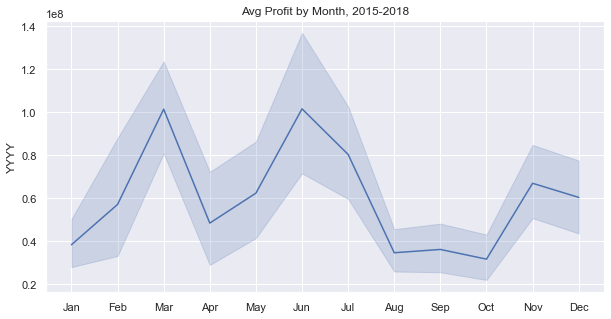

In [31]:
sns.set_style("darkgrid", {"grid.linestyle":":"})
sns.set(rc={'figure.figsize':(10,5)})

ax = sns.lineplot(x="month", y = "gross", data = recent_df)

ax.set_xlabel("")
ax.set_ylabel("YYYY")
ax.set_title("Avg Profit by Month, 2015-2018")



A graph of profits by month indicates that the months with highest success rates tend to be early spring, early summer, and to a lesser degree, the holiday season. 

### Average Budget and Gross Income
The next plot shows the budget and gross income on average, by month. This will indicate if there is a correlation bwtween the two.

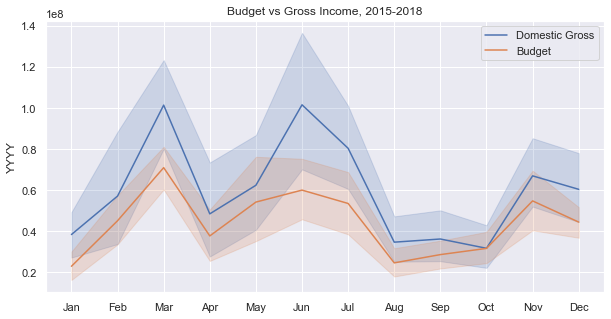

In [32]:

ax = sns.lineplot(x="month", y = "gross", data = recent_df)
ax1 = sns.lineplot(x="month", y = "budget", data = recent_df)


ax.set_xlabel("")
ax.set_ylabel("YYYY")
ax.set_title("Budget vs Gross Income, 2015-2018")
ax.legend(labels=["Domestic Gross","Budget"])

sns.set_style("darkgrid", {"grid.linestyle":":"})
sns.set(rc={'figure.figsize':(10,5)})

This graph verifies that increased budgets behind a movie's production seems to directly effect its domestic gross income, and thereby its profitability. 

### Movies by Genre
Next we break down these findings by Genre of movie, to see whcih of the most popular Genres tend to be more successful in general, and during which times of year.

In [33]:
recent_df['genres'].value_counts()

Drama                         91
Documentary                   52
Comedy                        35
Adventure,Animation,Comedy    32
Comedy,Drama                  23
                              ..
Horror,Music,Thriller          1
Adventure,Animation,Family     1
Comedy,Horror                  1
Music                          1
Biography,Drama,Musical        1
Name: genres, Length: 192, dtype: int64

We need to break down each movie in our data into individual genres. If a film is listed as a Comedy and Drama ,for example, it will become two separate entries, as each genre separately.

In [34]:
#remove genre commas, and separate individual words into lists
recent_df['genres'] = recent_df['genres'].str.split(',')

In [38]:
#genres will now be arrays of strings
recent_df.head()

,movie,genres,budget,gross,profit,month,year,monthNum,averagerating
2408,Split,"[Action, Drama, Sport]",5000000,138141585,133141585,Jan,2017,1,5.4
2472,Ride Along 2,"[Action, Comedy, Crime]",40000000,90862685,50862685,Jan,2016,1,5.9
491,Paddington,"[Adventure, Comedy, Family]",55000000,76223578,21223578,Jan,2015,1,7.2
2429,Blackhat,"[Action, Crime, Thriller]",70000000,8005980,-61994020,Jan,2015,1,5.4
2423,Above and Beyond,[Documentary],1300000,288751,-1011249,Jan,2015,1,NaN


In [39]:
#separate lists of genres into new row entries

genre_df = recent_df.explode('genres')

genre_df['genres'].value_counts()

Drama          452
Comedy         232
Action         212
Adventure      167
Thriller       129
Crime          103
Horror         103
Biography      100
Documentary     82
Romance         77
Mystery         65
Sci-Fi          61
Fantasy         60
Animation       51
History         41
Family          40
Music           26
Sport           23
War             11
Musical          7
Western          3
News             1
Name: genres, dtype: int64

Some of these genres only appear a small number of times, which could skew data. So we will remove all entries of a genre that appears under 50 times.

In [51]:
#remove lowest values
value_counts = genre_df['genres'].value_counts()
genre_df = genre_df[~genre_df['genres'].isin(value_counts[value_counts <= 50].index)]

#### Grouping Data
Here the data is grouped by genre, and the average values of each genre are calculated. The important average in this case is the profit, shown below.

In [57]:
profit_by_genre = genre_df.groupby('genres').mean()
profit_by_genre.reset_index(level=0, inplace=True)
profit_by_genre.drop('year', axis=1, inplace=True)

profit_by_genre[['genres','profit']].head()

,genres,profit
0,Action,9.817991e+06
1,Adventure,2.261242e+07
2,Animation,5.461833e+07
3,Biography,9.994019e+06
4,Comedy,2.464532e+07


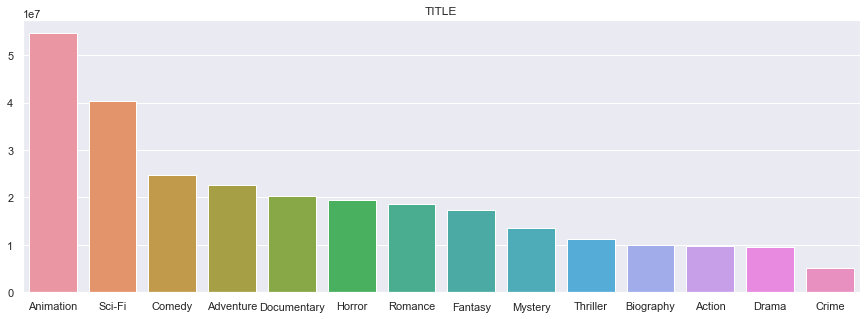

In [58]:
ax = sns.barplot(x='genres', y = "profit", data = profit_by_genre, 
                 order=profit_by_genre.sort_values('profit', ascending=False).genres)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("TITLE")

sns.set_style("darkgrid", {"grid.linestyle":":"})
sns.set(rc={'figure.figsize':(13,5)})

Animation and Sci-Fi genres easily beat out the competition in terms of average profits, but it's worth looking at the most popular genres on a month-to-month basis. We'll look at the top 4.

#### Most Popular Genres by Month
With new dataframes for each of the most popular genres, we can visualize how each of these genres do on a month to month basis. 

In [62]:
#create separate dataframes for each genre

animation_df = genre_df[genre_df['genres']=='Animation'].groupby('month').mean().sort_values('monthNum')
scifi_df = genre_df[genre_df['genres']=='Sci-Fi'].groupby('month').mean().sort_values('monthNum')
comedy_df = genre_df[genre_df['genres']=='Comedy'].groupby('month').mean().sort_values('monthNum')
adventure_df = genre_df[genre_df['genres']=='Adventure'].groupby('month').mean().sort_values('monthNum')

animation_df.reset_index(level=0, inplace=True)
scifi_df.reset_index(level=0, inplace=True)
comedy_df.reset_index(level=0, inplace=True)
adventure_df.reset_index(level=0, inplace=True)

In [63]:
#confirm dataframe successfully created
scifi_df.head()

,month,budget,gross,profit,year,monthNum,averagerating
0,Jan,2.233333e+07,2.065966e+07,-1.673671e+06,2016.333333,1.0,5.966667
1,Feb,9.950000e+07,1.964146e+08,9.691458e+07,2015.750000,2.0,5.725000
2,Mar,1.030000e+08,8.286669e+07,-2.013331e+07,2017.142857,3.0,6.514286
3,Apr,6.717857e+07,1.467128e+08,7.953427e+07,2017.000000,4.0,6.828571
4,May,1.444429e+08,1.786342e+08,3.419131e+07,2016.000000,5.0,6.585714


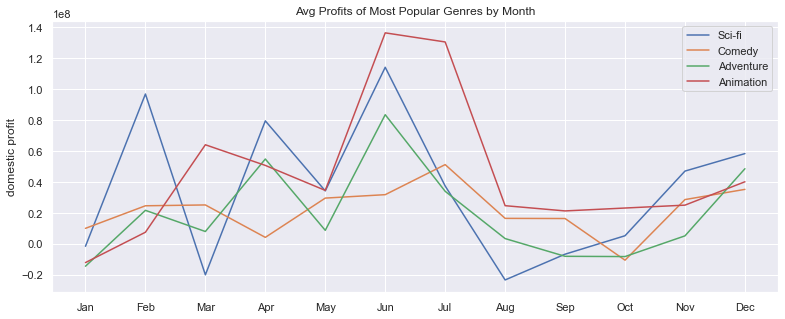

In [64]:
ax = sns.lineplot(x="month", y = "profit", data = scifi_df)
ax1 = sns.lineplot(x="month", y = "profit", data = comedy_df)
ax2 = sns.lineplot(x="month", y = "profit", data = adventure_df)
ax3 = sns.lineplot(x="month", y = "profit", data = animation_df)

ax.set_xlabel("")
ax.set_ylabel("domestic profit")
ax.set_title("Avg Profits of Most Popular Genres by Month")
ax.legend(labels=['Sci-fi', 'Comedy', 'Adventure', 'Animation'])

sns.set_style("darkgrid", {"grid.linestyle":":"})
sns.set(rc={'figure.figsize':(15,5)})

This indicates that Animated films are most profitable in the summer. However, in February, when most movies are not very profitable, Sci-fi films stand a chance of success. Additionally, while Comedy films are at least moderately profitable, it is inadvisable to focus on them. This is especially true during the summer, when other types of movies do far better.

### Reviews vs Profits
Finally, we will analyze whether the profitability of films has any correlation to the average reviews they receive. This can be simply visualized on a scatter plot.

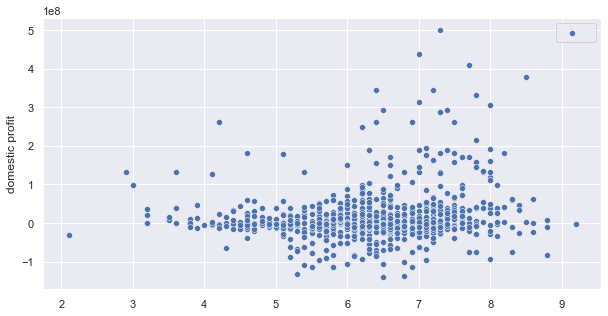

In [68]:
ax = sns.scatterplot(x="averagerating", y = "profit", data = recent_df)

ax.set_xlabel("")
ax.set_ylabel("domestic profit")
ax.set_title("")
ax.legend(labels=[''])

sns.set_style("darkgrid", {"grid.linestyle":":"})
sns.set(rc={'figure.figsize':(10,5)})

There does seem to be at least somewhat of a correlation. Next we will see if this varies depending on the genre.

[(5.0, 8.0)]

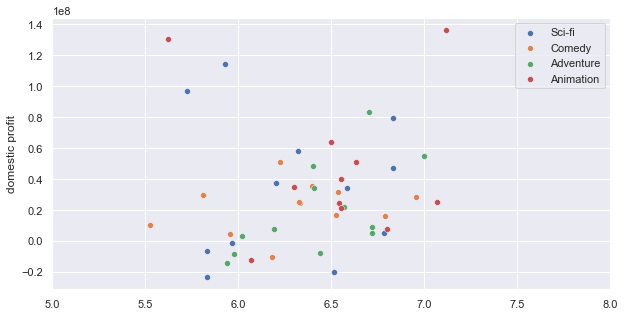

In [81]:
ax = sns.scatterplot(x="averagerating", y = "profit", data = scifi_df)
ax1 = sns.scatterplot(x="averagerating", y = "profit", data = comedy_df)
ax2 = sns.scatterplot(x="averagerating", y = "profit", data = adventure_df)
ax3 = sns.scatterplot(x="averagerating", y = "profit", data = animation_df)

ax.set_xlabel("")
ax.set_ylabel("domestic profit")
ax.set_title("")
ax.legend(labels=['Sci-fi', 'Comedy', 'Adventure', 'Animation'])

sns.set_style("darkgrid", {"grid.linestyle":":"})
sns.set(rc={'figure.figsize':(10,5)})
ax.set(xlim=(5,8))

This data isn't strong enough to identify any trends on a basis of genre, but does confirm that for the most popular genres in general, there is some correlation between higher average ratings and profitability.

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***